In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data.csv')
len(df)

11914

In [3]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


# Normalization

In [4]:
# Normalization of column names
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Filtering columns with object dtypes
string_columns = list(df.dtypes[df.dtypes == 'object'].index)

# Normalizing them for consistency
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

# Exploratory data analysis

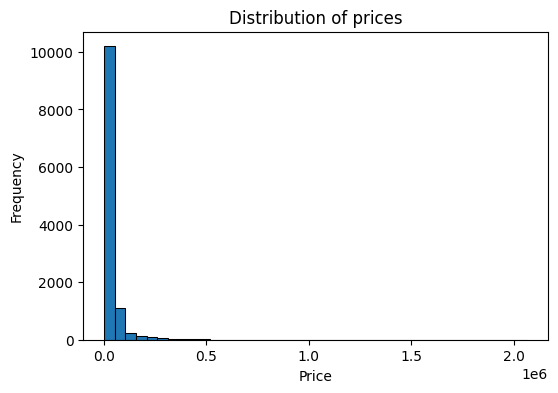

In [5]:
plt.figure(figsize=(6, 4))

sns.histplot(df.msrp, bins=40, alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

#### Concised view

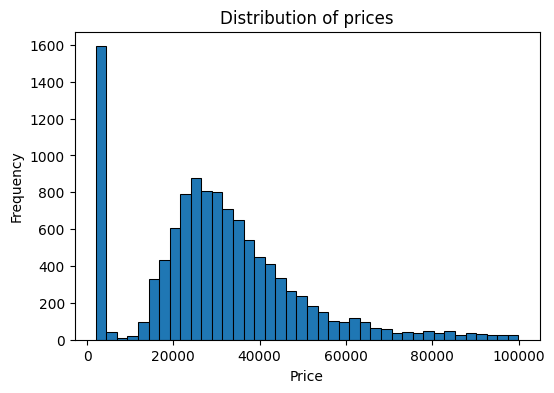

In [6]:
plt.figure(figsize=(6, 4))

sns.histplot(df.msrp[df.msrp < 100000], bins=40, alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

# Transformation of Data

In [7]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

## using Logarithmic Transformation on prices column

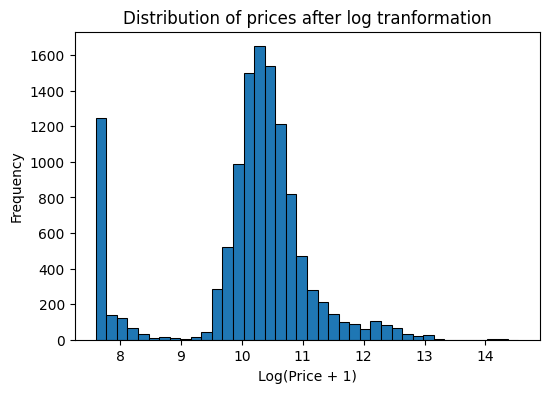

In [8]:
log_price = np.log1p(df.msrp)

plt.figure(figsize=(6, 4))

sns.histplot(log_price, bins=40, alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Distribution of prices after log tranformation')

plt.show()

## we will require only numerical data types for machine learning model. So for simplicity let's keep only numerical type columns

In [9]:
df = df.select_dtypes(include = ['int64','float64'])

In [10]:
df.isnull().sum()

year                 0
engine_hp           69
engine_cylinders    30
number_of_doors      6
highway_mpg          0
city_mpg             0
popularity           0
msrp                 0
dtype: int64

very small portion of data points contain missing values so we drop those rows

In [11]:
df = df.fillna(0)

In [12]:
df.isnull().sum()

year                0
engine_hp           0
engine_cylinders    0
number_of_doors     0
highway_mpg         0
city_mpg            0
popularity          0
msrp                0
dtype: int64

In [13]:
df['number_of_doors'].value_counts()

number_of_doors
4.0    8353
2.0    3160
3.0     395
0.0       6
Name: count, dtype: int64

There is no car with 0 doors

In [14]:
df = df[df['number_of_doors'] != 0]

# Setting up validation framework

In [15]:
np.random.seed(2)

## Shuffling data

In [16]:
n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

In [17]:
idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

## 60+20+20 Train+Validation+Test set

In [18]:
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [19]:
y_train_orig = df_train.msrp.values
y_val_orig = df_val.msrp.values
y_test_orig = df_test.msrp.values

In [20]:
log_y_train = np.log1p(df_train.msrp.values)
log_y_val = np.log1p(df_val.msrp.values)
log_y_test = np.log1p(df_test.msrp.values)

In [21]:
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

# Modelling

## Simple Linear Regression

As a starting point let's predefine the weights and bias of a linear regression model

In [22]:
df_train.head()

,year,engine_hp,engine_cylinders,number_of_doors,highway_mpg,city_mpg,popularity
925,2015,520.0,6.0,2.0,24,17,1715
11422,1999,158.0,6.0,4.0,22,16,535
9049,1995,115.0,4.0,2.0,30,23,1439
6626,2015,400.0,6.0,4.0,23,17,1715
7403,2007,255.0,6.0,4.0,22,14,1013


In [23]:
X_train = df_train.to_numpy()

In [24]:
def dummy_linear_regression(X):
    w0 = 2 # bias as 2
    wts = np.ones((X.shape[1], 1)) # for simplysity we keep all weights =1

    # Calculating price w0 + w1*x1 + w2*x2 + ....+ wn*xn using matrix multiplication
    pred = w0 + X@wts;    
    return pred
    

### lets test it directly. As we have pre computed model

In [25]:
dummy_linear_regression(X_train)

array([[4301.],
       [2742.],
       [3610.],
       ...,
       [3654.],
       [2936.],
       [7911.]], shape=(7146, 1))

## Actual Training of Linear Regression Model

In [26]:
def linear_regression(X, y):
    # Add a column of ones for the bias/intercept term
    X = np.column_stack([np.ones(X.shape[0]), X])
    
    # This is more stable than using np.linalg.inv()
    XTX = X.T @ X
    XTy = X.T @ y
    
    # Solve the system of linear equations (XTX)w = XTy for w
    w = np.linalg.solve(XTX, XTy)
    
    return w

### Training with original data with no logarithmic transformation

In [27]:
w = linear_regression(X_train,y_train_orig)
w[0],w[1:]

(np.float64(-164496.17181020157),
 array([ 3.65480097e+01,  3.34391212e+02,  6.53896288e+03, -4.90471195e+03,
         4.86984338e+02,  1.06302221e+03, -3.17432069e+00]))

In [28]:
y_pred = X_train@w[1:]+w[0]
y_pred

array([136770.89342156,   7035.78996578,  -2290.28176636, ...,
        10538.91035923,  31896.92837212,   -515.39733968], shape=(7146,))

<Axes: ylabel='Count'>

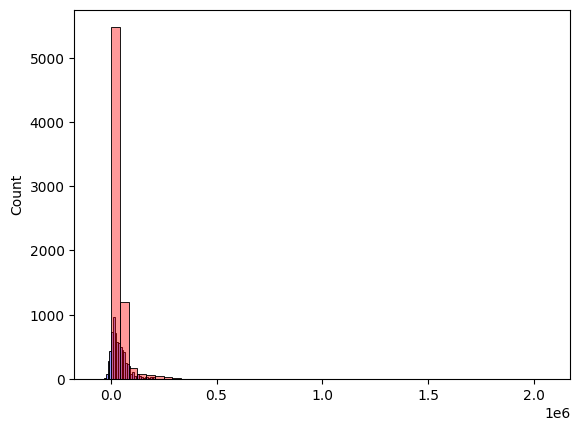

In [29]:
sns.histplot(y_pred, color='blue', alpha=0.4, bins=50,  label='y_pred')
sns.histplot(y_train_orig, color='red', alpha=0.4, bins=50, label='y_train_orig')

## Training with logarithmic transformation on prices

In [30]:
w_with_log_transform = linear_regression(X_train,log_y_train)
w_with_log_transform[0],w_with_log_transform[1:]

(np.float64(-181.01825893171366),
 array([ 9.44258274e-02,  3.86632053e-03,  6.84665302e-02, -2.50587975e-02,
        -3.36901987e-03,  1.06294020e-02, -4.88019831e-05]))

In [31]:
y_pred_log = X_train@w_with_log_transform[1:] + w_with_log_transform[0]

<Axes: ylabel='Count'>

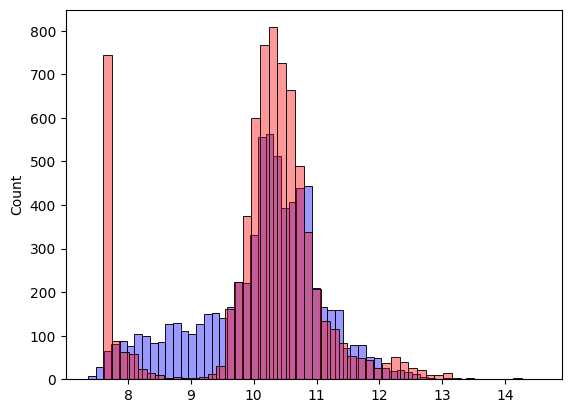

In [32]:
sns.histplot(y_pred_log,color='blue',alpha=0.4,bins=50)
sns.histplot(log_y_train,color='red',alpha=0.4,bins=50)

## using validation set

In [33]:
subset_val = df_val.values
y_pred_val_log = subset_val@w_with_log_transform[1:] + w_with_log_transform[0]

<Axes: ylabel='Count'>

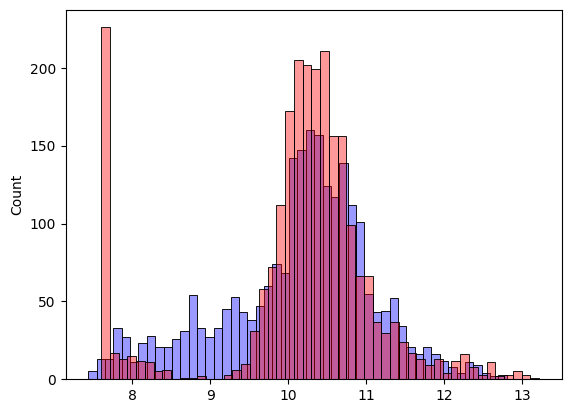

In [34]:
sns.histplot(y_pred_val_log,color='blue',alpha=0.4,bins=50)
sns.histplot(log_y_val,color='red',alpha=0.4,bins=50)

# RMSE

In [35]:
def root_mean_squared_error(y,y_pred):
    se = (y-y_pred)**2
    mse = se.mean()
    return np.sqrt(mse)

Without log transformation

In [36]:
root_mean_squared_error(y_train_orig,y_pred)

np.float64(47648.04971669507)

With log transformation

In [37]:
root_mean_squared_error(np.exp(log_y_train),np.exp(y_pred_log))

np.float64(45600.21511423705)

# Validation

## Without log transformation

In [38]:
X_val = df_val.values

In [39]:
y_val_pred = X_val@w[1:]+w[0]

In [40]:
root_mean_squared_error(y_val_orig,y_val_pred)

np.float64(32519.942857031667)

## With log transformation

In [41]:
log_y_val_pred = X_val@w_with_log_transform[1:]+w_with_log_transform[0]

In [42]:
root_mean_squared_error(np.exp(log_y_val),np.exp(log_y_val_pred))

np.float64(32700.727667690033)

# Simple feature engineering

In [43]:
def add_feature_age(df_train):
    df_dummy = df_train.copy()
    # so let's assume we are in this max year and calculate the age of every model
    df_dummy['year'] = df_train['year'].max()-df_dummy['year']
    df_dummy.rename(columns={'year':'age'},inplace=True)
    return df_dummy

In [44]:
new_df = add_feature_age(df_train)
new_df

,age,engine_hp,engine_cylinders,number_of_doors,highway_mpg,city_mpg,popularity
925,2,520.0,6.0,2.0,24,17,1715
11422,18,158.0,6.0,4.0,22,16,535
9049,22,115.0,4.0,2.0,30,23,1439
6626,2,400.0,6.0,4.0,23,17,1715
7403,10,255.0,6.0,4.0,22,14,1013
...,...,...,...,...,...,...,...
5285,3,240.0,6.0,4.0,26,19,617
2420,0,200.0,4.0,4.0,31,22,873
2779,2,200.0,4.0,4.0,25,19,1385
3708,0,241.0,4.0,4.0,29,22,617


In [45]:
X_with_age = new_df.values

In [46]:
X_with_age

array([[2.000e+00, 5.200e+02, 6.000e+00, ..., 2.400e+01, 1.700e+01,
        1.715e+03],
       [1.800e+01, 1.580e+02, 6.000e+00, ..., 2.200e+01, 1.600e+01,
        5.350e+02],
       [2.200e+01, 1.150e+02, 4.000e+00, ..., 3.000e+01, 2.300e+01,
        1.439e+03],
       ...,
       [2.000e+00, 2.000e+02, 4.000e+00, ..., 2.500e+01, 1.900e+01,
        1.385e+03],
       [0.000e+00, 2.410e+02, 4.000e+00, ..., 2.900e+01, 2.200e+01,
        6.170e+02],
       [0.000e+00, 1.600e+02, 4.000e+00, ..., 4.000e+01, 2.700e+01,
        5.657e+03]], shape=(7146, 7))

## Training without log transformation

In [47]:
w_with_age = linear_regression(X_with_age,y_train_orig)
w_with_age[0],w_with_age[1:]

(np.float64(-90778.83614479103),
 array([-3.65480098e+01,  3.34391212e+02,  6.53896288e+03, -4.90471195e+03,
         4.86984338e+02,  1.06302221e+03, -3.17432069e+00]))

In [48]:
y_pred_with_age = X_with_age@w_with_age[1:] + w_with_age[0]

In [49]:
root_mean_squared_error(y_train_orig,y_pred_with_age)

np.float64(47648.04971669508)

<Axes: ylabel='Count'>

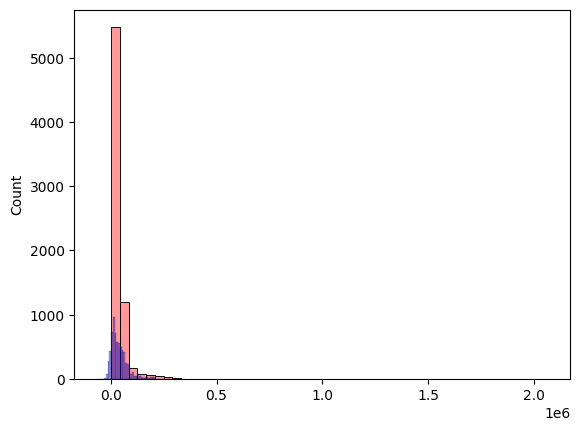

In [50]:
sns.histplot(y_train_orig,color='red',alpha=0.4,bins=50)
sns.histplot(y_pred_with_age,color='blue',alpha=0.4,bins=50)

## Training with log transformation

In [51]:
w_with_log_transform_and_age = linear_regression(X_with_age,log_y_train)
w_with_log_transform_and_age[0],w_with_log_transform_and_age[1:]

(np.float64(9.438634909446836),
 array([-9.44258274e-02,  3.86632053e-03,  6.84665302e-02, -2.50587975e-02,
        -3.36901987e-03,  1.06294020e-02, -4.88019831e-05]))

In [52]:
log_y_pred_with_age = X_with_age@w_with_log_transform_and_age[1:] + w_with_log_transform_and_age[0]

In [53]:
root_mean_squared_error(np.exp(log_y_train),np.exp(log_y_pred_with_age))

np.float64(45600.215114326595)

<Axes: ylabel='Count'>

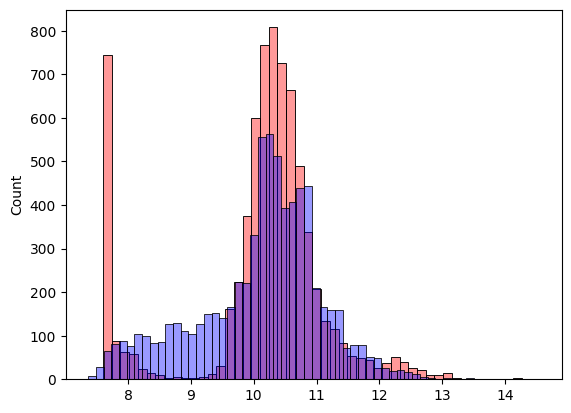

In [54]:
sns.histplot(log_y_train,color='red',alpha=0.4,bins=50)
sns.histplot(log_y_pred_with_age,color='blue',alpha=0.4,bins=50)

## Validation

In [55]:
X_val_with_age = add_feature_age(df_val).values

### Model that was trained without log transformation

In [56]:
y_val_pred_with_age = X_val_with_age@w_with_age[1:] +w_with_age[0]
root_mean_squared_error(y_val_orig,y_val_pred_with_age)

np.float64(32519.942857031045)

<Axes: ylabel='Count'>

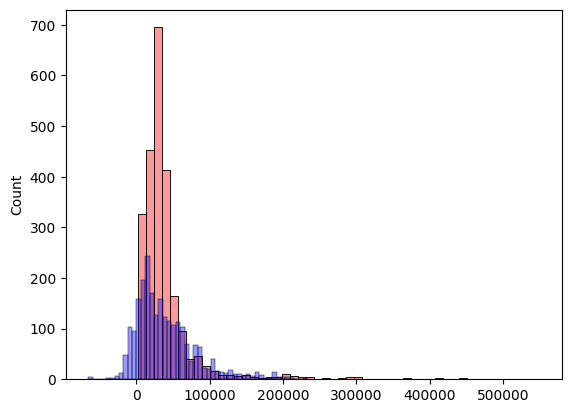

In [57]:
sns.histplot(y_val_orig,color='red',alpha=0.4,bins=50)
sns.histplot(y_val_pred_with_age,color='blue',alpha=0.4,bins=50)

### Model that was trained with log transformation

In [58]:
log_y_val_pred_with_age = X_val_with_age@w_with_log_transform_and_age[1:]+w_with_log_transform_and_age[0]
root_mean_squared_error(np.exp(log_y_val),np.exp(log_y_val_pred_with_age))

np.float64(32700.727667644605)

<Axes: ylabel='Count'>

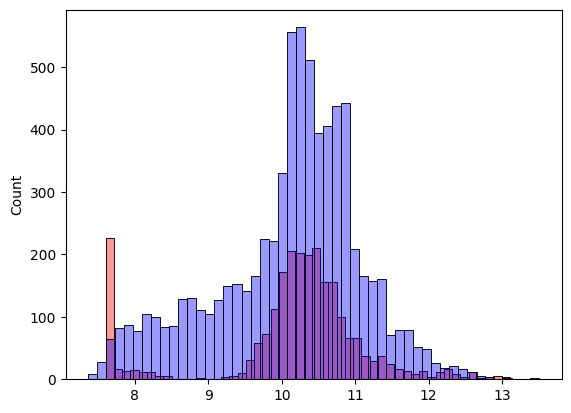

In [59]:
sns.histplot(log_y_val,color='red',alpha=0.4,bins=50)
sns.histplot(log_y_pred_with_age,color='blue',alpha=0.4,bins=50)

# Categorical variables

In [60]:
df_train.columns

Index(['year', 'engine_hp', 'engine_cylinders', 'number_of_doors',
       'highway_mpg', 'city_mpg', 'popularity'],
      dtype='object')

In [61]:
df_val.columns

Index(['year', 'engine_hp', 'engine_cylinders', 'number_of_doors',
       'highway_mpg', 'city_mpg', 'popularity'],
      dtype='object')

In [62]:
df.nunique()

year                  28
engine_hp            357
engine_cylinders       9
number_of_doors        3
highway_mpg           59
city_mpg              65
popularity            48
msrp                6046
dtype: int64

In [63]:
def make_df_one_hot_encoding(df,columns):
    new_df = df.copy()
    new_df['year'] = new_df['year'].max()-new_df['year'];
    new_df.rename(columns = {'year':'age'},inplace=True)
    for column in columns:
        unique_values = list(new_df[column].unique().astype('int'))
        for value in unique_values:
            new_df[column+'_%s'% value] = (new_df[column] == value).astype('int')
        del new_df[column]
        return new_df

In [64]:
df_train_1_hot_enc = make_df_one_hot_encoding(df_train,['number_of_doors'])
df_train_1_hot_enc.head()

,age,engine_hp,engine_cylinders,highway_mpg,city_mpg,popularity,number_of_doors_2,number_of_doors_4,number_of_doors_3
925,2,520.0,6.0,24,17,1715,1,0,0
11422,18,158.0,6.0,22,16,535,0,1,0
9049,22,115.0,4.0,30,23,1439,1,0,0
6626,2,400.0,6.0,23,17,1715,0,1,0
7403,10,255.0,6.0,22,14,1013,0,1,0


In [65]:
df_train['number_of_doors'].value_counts()

number_of_doors
4.0    5016
2.0    1910
3.0     220
Name: count, dtype: int64

In [66]:
df_val_1_hot_enc = make_df_one_hot_encoding(df_val,['number_of_doors'])
df_test_1_hot_enc = make_df_one_hot_encoding(df_test,['number_of_doors'])

### training

In [67]:
X_train_with_1_hot_enc = df_train_1_hot_enc.values
X_train_with_1_hot_enc

array([[  2., 520.,   6., ...,   1.,   0.,   0.],
       [ 18., 158.,   6., ...,   0.,   1.,   0.],
       [ 22., 115.,   4., ...,   1.,   0.,   0.],
       ...,
       [  2., 200.,   4., ...,   0.,   1.,   0.],
       [  0., 241.,   4., ...,   0.,   1.,   0.],
       [  0., 160.,   4., ...,   0.,   1.,   0.]], shape=(7146, 9))

In [68]:
X_train_with_1_hot_enc.shape,y_train_orig.shape

((7146, 9), (7146,))

In [69]:
w = linear_regression(X_train_with_1_hot_enc,y_train_orig)
w[0],w[1:]

(np.float64(-109402.22790035132),
 array([-3.88699274e+01,  3.33230016e+02,  6.58594160e+03,  4.78588644e+02,
         1.06470857e+03, -3.13145585e+00,  9.10876508e+03, -7.76719350e+02,
         1.66054054e+03]))

In [70]:
y_pred_on_train_1_hot_enc = X_train_with_1_hot_enc@w[1:] +w[0]

In [71]:
training_rmse = root_mean_squared_error(y_train_orig,y_pred_on_train_1_hot_enc)
training_rmse

np.float64(47646.23418705186)

<Axes: ylabel='Count'>

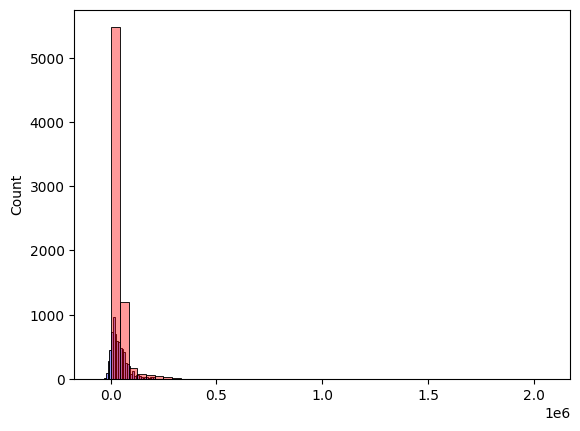

In [72]:
sns.histplot(y_pred_on_train_1_hot_enc,color = 'blue',alpha = 0.4,bins=50)
sns.histplot(y_train_orig,color = 'red',alpha = 0.4,bins=50)

### Validation

In [73]:
X_val_with_1_hot_enc = df_val_1_hot_enc.values

In [74]:
y_pred_1_hot_enc = X_val_with_1_hot_enc@w[1:]+w[0]

In [75]:
root_mean_squared_error(y_val_orig,y_pred_1_hot_enc)

np.float64(32517.57433248727)

<Axes: ylabel='Count'>

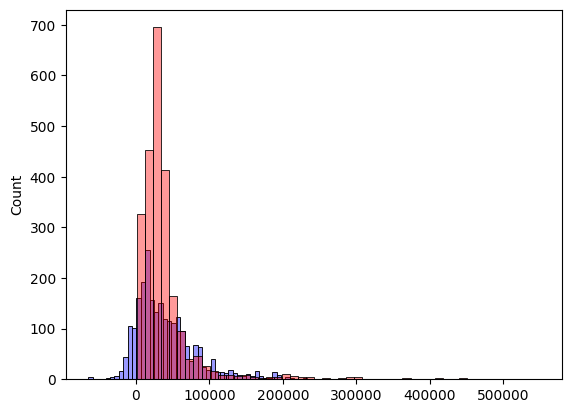

In [76]:
sns.histplot(y_pred_1_hot_enc,color = 'blue',alpha = 0.4,bins=50)
sns.histplot(y_val_orig,color = 'red',alpha = 0.4,bins=50)

### with log transformed data

### training

In [77]:
w = linear_regression(X_train_with_1_hot_enc,log_y_train)
w[0],w[1:]

(np.float64(26.552457730181505),
 array([-9.46143947e-02,  3.77201761e-03,  7.22817605e-02, -4.05085000e-03,
         1.07663544e-02, -4.53208484e-05, -1.71399994e+01, -1.71962940e+01,
        -1.73716216e+01]))

In [78]:
log_y_pred_1_hot_enc = X_train_with_1_hot_enc@w[1:]+w[0]

<Axes: ylabel='Count'>

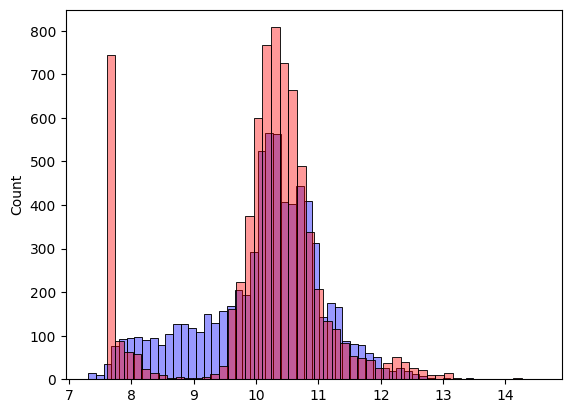

In [79]:
sns.histplot(log_y_pred_1_hot_enc,color = 'blue',alpha = 0.4,bins=50)
sns.histplot(log_y_train,color = 'red',alpha = 0.4,bins=50)

### validation

In [80]:
log_y_pred_1_hot_enc = X_val_with_1_hot_enc@w[1:]+w[0]

In [81]:
root_mean_squared_error(log_y_val,log_y_pred_1_hot_enc)

np.float64(0.5165038116680333)

In [82]:
root_mean_squared_error(log_y_val,log)

ValueError: operands could not be broadcast together with shapes (2381,) (7146,) 

In [ ]:
sns.histplot(log_y_pred_1_hot_enc,color = 'blue',alpha = 0.4,bins=50)
sns.histplot(log_y_val,color = 'red',alpha = 0.4,bins=50)